In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.model_selection import train_test_split

stock1 = pd.read_csv('data/stock_1.csv')

ModuleNotFoundError: No module named 'statsmodels'

Parameters to change:
- Time interval for change in vol (right now every 30 seconds)
- Forecasting next 2 min by training on 8 min 

In [10]:
stock1["WAP"] = (stock1["bid_price1"] * stock1["ask_size1"] + stock1["ask_price1"] * stock1["bid_size1"]) / (stock1["bid_size1"] + stock1["ask_size1"])
#stock1 <- stock1 %>% mutate(BidAskSpread = ask_price1 / bid_price1 - 1)

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,WAP
0,5,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100,1,1.000785
1,5,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100,1,1.001032
2,5,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125,1,1.000780
3,5,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36,1,1.001411
4,5,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25,1,1.001115


In [118]:
log_r1 = []
time_IDs = np.unique(stock1.iloc[:, 0])
for i in range(len(time_IDs)):
    sec = stock1.loc[stock1.iloc[:, 0] == time_IDs[i], 'seconds_in_bucket'].values
    price = stock1.loc[stock1.iloc[:, 0] == time_IDs[i], 'WAP'].values
    log_r = np.log(price[1:] / price[0:(len(price) - 1)])
    log_r1.append(pd.DataFrame({'time': sec[1:], 'log_return': log_r}))
    time_no_change = np.setdiff1d(np.arange(1, 601), log_r1[i]['time'].values)
    if len(time_no_change) > 0:
        new_df = pd.DataFrame({'time': time_no_change, 'log_return': 0})
        log_r1[i] = pd.concat([log_r1[i], new_df])
        log_r1[i] = log_r1[i].sort_values(by='time')

vol = []
def comp_vol(x):
    return np.sqrt(np.sum(x ** 2))

for i in range(len(log_r1)):
    log_r1[i]['time_bucket'] = np.ceil(log_r1[i]['time'] / 30)
    vol.append(log_r1[i].groupby('time_bucket')['log_return'].agg(comp_vol).reset_index())
    vol[i].columns = ['time_bucket', 'volatility']


In [119]:

ans = []
for i in range(len(vol)):
    for j in range(20):
        ans.append(vol[i]["volatility"][j])
y = np.array(ans)

train, test = train_test_split(y, train_size=8000)

In [121]:
# Fit the model automatically
model = pm.auto_arima(train, seasonal=False, m=12)

params = model.summary()
print(params)


# make the forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

C:\Users\cecil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8000
Model:               SARIMAX(2, 0, 3)   Log Likelihood               47975.407
Date:                Thu, 30 Mar 2023   AIC                         -95936.814
Time:                        21:17:31   BIC                         -95887.904
Sample:                             0   HQIC                        -95920.073
                               - 8000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001   9.77e-06     14.442      0.000       0.000       0.000
ar.L1          0.0958      0.002     38.857      0.000       0.091       0.101
ar.L2          0.7636      0.002    320.995      0.0

[   0    1    2 ... 9997 9998 9999]
8000
2000
2000


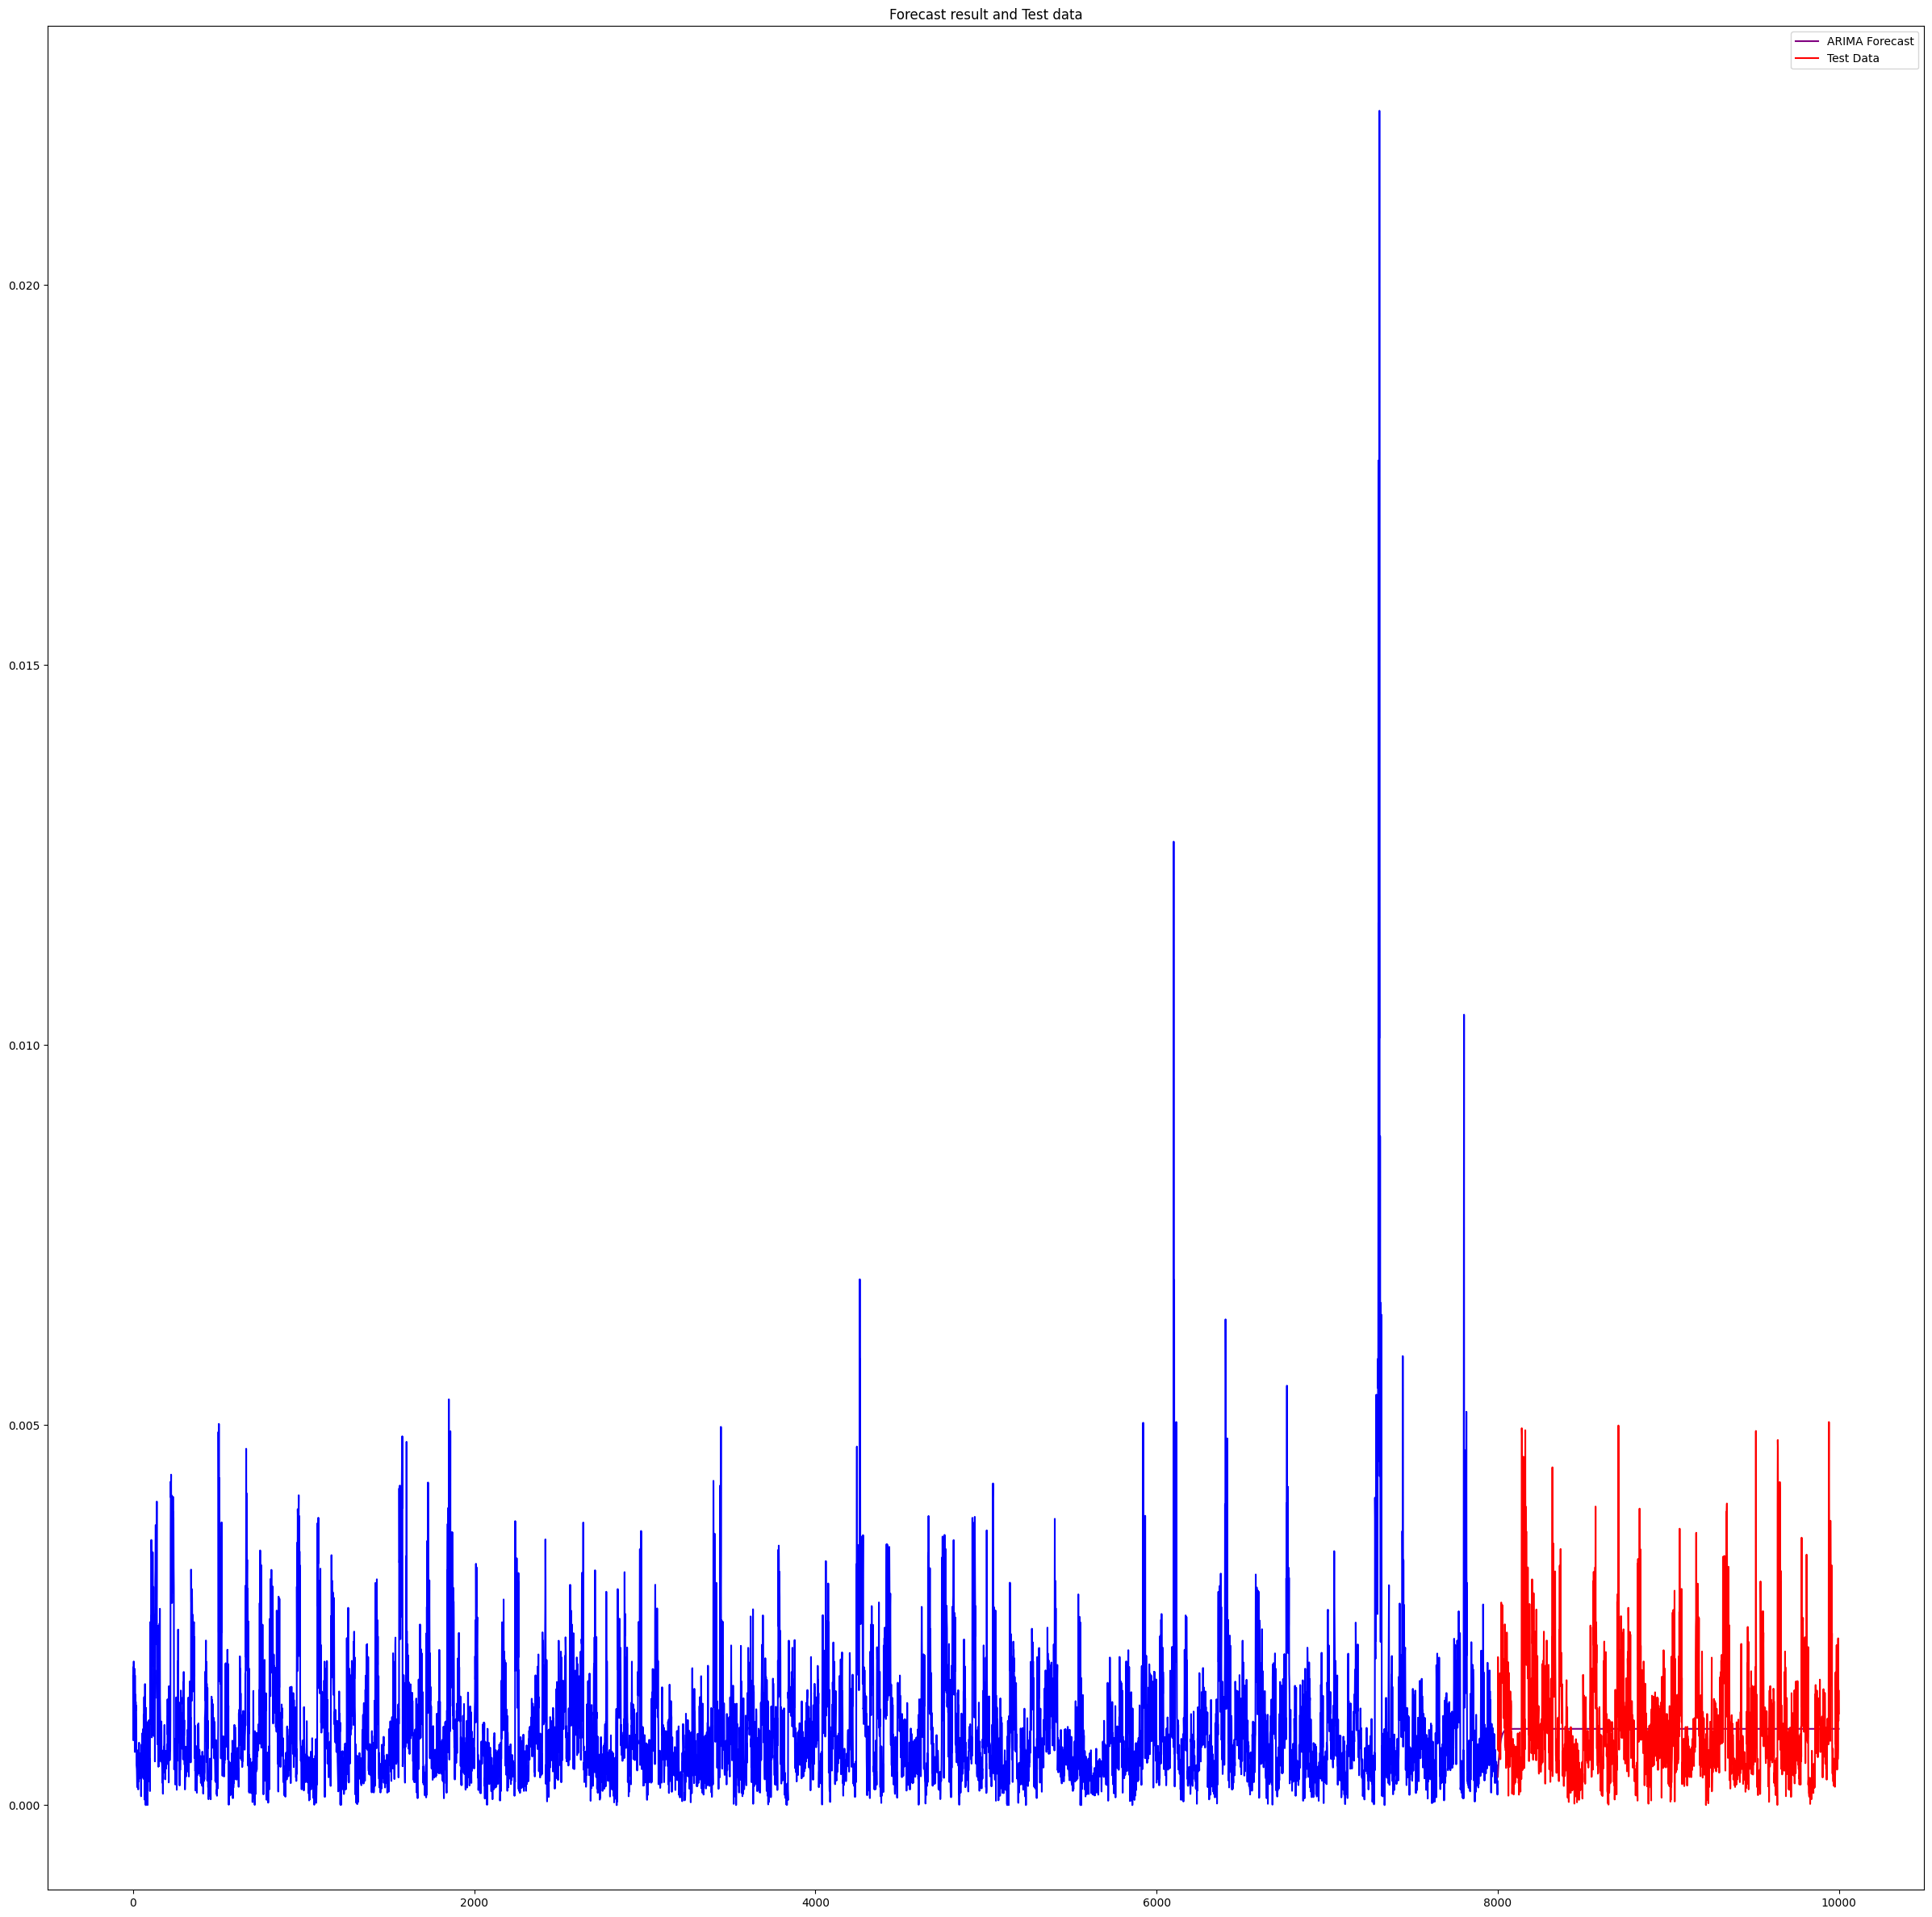

In [100]:
plt.figure(figsize  = (30,30))
plt.title('Forecast result and Test data')
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
print(x)
print(len(train))
print(len(test))
print(len(forecasts))
plt.plot(x[:8000], train, c='blue')
plt.plot(x[8000:], forecasts, c='purple', label = 'ARIMA Forecast')
plt.plot(x[8000:], test, c='red', label = 'Test Data')
plt.legend()
plt.show()

In [102]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(testvalues, forecastsvalues)
print("MSE:", mse)

MSE: 5.709204049120728e-07


In [103]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(testvalues, forecastsvalues)
print("MAE:", mae)

MAE: 0.0005424981058501251
